In [5]:
import torch 
import torch.nn as nn 
from pprint import pprint
from src.traintest.device import select_device 
from src.data import fetch_dataset, dataloader
from src.models.linear import Linear
from src.traintest.regularizers import * 
from src.metrics.metrics import * 
from src.traintest.train_model import train
from src.traintest.test_model import test
from src.metrics.loggers import Logger, plot_loggers
import matplotlib.pyplot as plt 
import copy

device = select_device()

training_data, test_data = fetch_dataset("MNIST", verbose=False)

train_dataloader, test_dataloader = dataloader(
    training_data, test_data, 
    train_batch_size=-1, 
    test_batch_size=-1
)

torch.Size([10, 784])
torch.Size([10])


In [12]:
epochs = 30
lr = 1e-3
num_exp = 6

torch.manual_seed(0)
model_outline = Linear(data_shape = (28, 28, ), target_size = 10).to(device)

loggers = [Logger() for _ in range(num_exp)]
models = [copy.deepcopy(model_outline) for _ in range(num_exp)]
optimizers = [torch.optim.SGD(models[i].parameters(), lr=lr, momentum=0.9) for i in range(num_exp)]
losses = [nn.CrossEntropyLoss() for _ in range(num_exp)]
regularizers = [
    None, 
    L1_SoftThreshold(models[1], device, lmbda=1e-2, tau=lr), 
    L1_Proximal(models[2], device, lmbda=1e-2, tau=lr, optimizer="SGD"), 
    L2_Regularizer(models[3], optimizers[3], device, lmbda=1e-2), 
    PQI_Proximal(models[4], device, p=1., q=2., lmbda=0.1, tau=lr, optimizer="SGD"), 
    PQI_Proximal(models[5], device, p=1., q=2., lmbda=1.0, tau=lr, optimizer="SGD")
]

for exp in range(num_exp): 
    for t in range(epochs): 
        
        train_dict = train(train_dataloader, models[exp], losses[exp], optimizers[exp], device, regularizers[exp], t)
        test_dict = test(test_dataloader, models[exp], losses[exp], device, regularizers[exp])
        
        loggers[exp].push(
            train_loss = train_dict["loss"], 
            test_loss = test_dict["loss"], 
            test_accuracy = test_dict["accuracy"], 
            PQI_sparsity = PQI(models[exp], device, 1, 2).item(), 
            L0_sparsity = L0_sparsity(models[exp])
        )
        
        pprint(f"L0 Sparsity : {100 * L0_sparsity(models[exp])}%")
        pprint(f"PQ Sparsity : {PQI(models[exp], device, 1, 2).item()}")



Epoch 0
-------------------------------
loss: 2.551288  [60000/60000]
Epoch Time : 8.25
Test Error: 
 Accuracy: 5.2%, Avg loss: 2.545088 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.1367872953414917'
Epoch 1
-------------------------------
loss: 2.551288  [60000/60000]
Epoch Time : 8.09
Test Error: 
 Accuracy: 5.5%, Avg loss: 2.529773 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.13679856061935425'
Epoch 2
-------------------------------
loss: 2.536373  [60000/60000]
Epoch Time : 7.91
Test Error: 
 Accuracy: 6.0%, Avg loss: 2.501071 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.13681751489639282'
Epoch 3
-------------------------------
loss: 2.508411  [60000/60000]
Epoch Time : 8.01
Test Error: 
 Accuracy: 6.6%, Avg loss: 2.461018 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.1368577480316162'
Epoch 4
-------------------------------
loss: 2.469371  [60000/60000]
Epoch Time : 8.2
Test Error: 
 Accuracy: 7.8%, Avg loss: 2.411654 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.13693362474441528'
Epoch 5
---------------

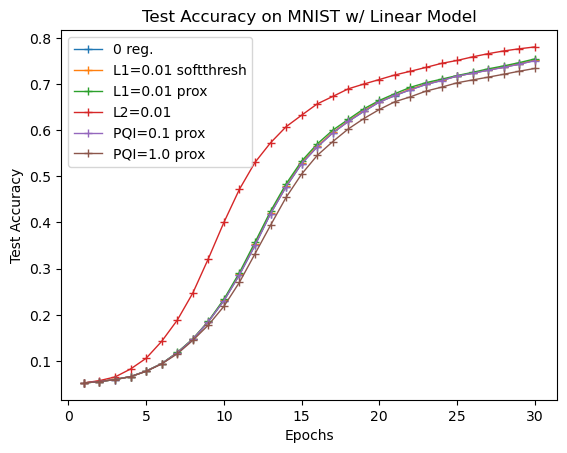

In [16]:
plt.plot(range(1, epochs+1), loggers[0].test_accuracies, marker="+", label="0 reg.", linewidth=1)
plt.plot(range(1, epochs+1), loggers[1].test_accuracies, marker="+", label="L1=0.01 soft", linewidth=1)
plt.plot(range(1, epochs+1), loggers[2].test_accuracies, marker="+", label="L1=0.01 prox", linewidth=1)
plt.plot(range(1, epochs+1), loggers[3].test_accuracies, marker="+", label="L2=0.01", linewidth=1)
plt.plot(range(1, epochs+1), loggers[4].test_accuracies, marker="+", label="PQI=0.1 prox", linewidth=1)
plt.plot(range(1, epochs+1), loggers[5].test_accuracies, marker="+", label="PQI=1.0 prox", linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy on MNIST w/ Linear Model")
plt.legend()
plt.show() 

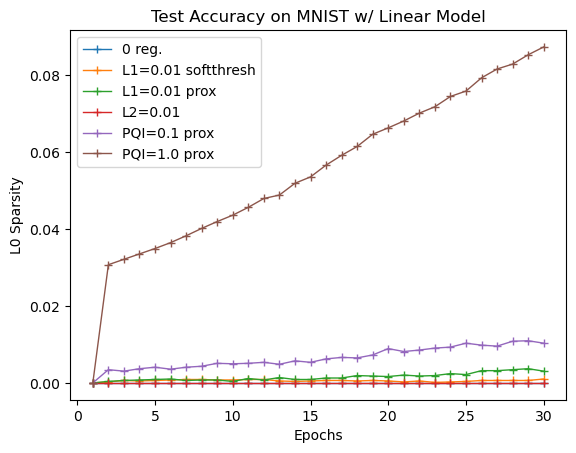

In [17]:
plt.plot(range(1, epochs+1), loggers[0].L0_sparsities, marker="+", label="0 reg.", linewidth=1)
plt.plot(range(1, epochs+1), loggers[1].L0_sparsities, marker="+", label="L1=0.01 softthresh", linewidth=1)
plt.plot(range(1, epochs+1), loggers[2].L0_sparsities, marker="+", label="L1=0.01 prox", linewidth=1)
plt.plot(range(1, epochs+1), loggers[3].L0_sparsities, marker="+", label="L2=0.01", linewidth=1)
plt.plot(range(1, epochs+1), loggers[4].L0_sparsities, marker="+", label="PQI=0.1 prox", linewidth=1)
plt.plot(range(1, epochs+1), loggers[5].L0_sparsities, marker="+", label="PQI=1.0 prox", linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("L0 Sparsity")
plt.title("Test Accuracy on MNIST w/ Linear Model")
plt.legend()
plt.show() 

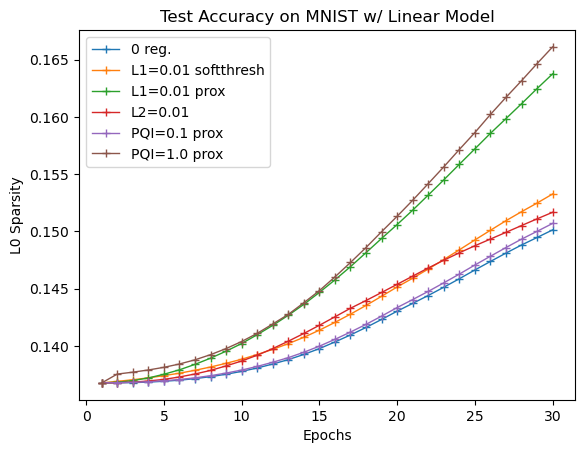

In [18]:
plt.plot(range(1, epochs+1), loggers[0].PQI_sparsities, marker="+", label="0 reg.", linewidth=1)
plt.plot(range(1, epochs+1), loggers[1].PQI_sparsities, marker="+", label="L1=0.01 softthresh", linewidth=1)
plt.plot(range(1, epochs+1), loggers[2].PQI_sparsities, marker="+", label="L1=0.01 prox", linewidth=1)
plt.plot(range(1, epochs+1), loggers[3].PQI_sparsities, marker="+", label="L2=0.01", linewidth=1)
plt.plot(range(1, epochs+1), loggers[4].PQI_sparsities, marker="+", label="PQI=0.1 prox", linewidth=1)
plt.plot(range(1, epochs+1), loggers[5].PQI_sparsities, marker="+", label="PQI=1.0 prox", linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("L0 Sparsity")
plt.title("Test Accuracy on MNIST w/ Linear Model")
plt.legend()
plt.show() 